# Predict which voter-eligible Colorado citizens actually voted in the 2016 US presidential election.

This is the Spring 2017, Harvard Statistics 149: Generalized Linear Models prediction contest/course project.

The goal of this project is to use the modeling methods you learned in Statistics 149 (and possibly other related methods) to analyze a data set on whether a Colorado voting-eligible citizen ended up actually voting in the 2016 US election. These data were kindly provided by moveon.org. The competition can be found [here](inclass.kaggle.com/c/who-voted) and ended April 30, 2017, at 10pm EDT.

## Analysis and interpretation of final model used in the prediction task

The goal of this notebook is to analyze progress throughout the competition and to attempt to interpret the final model to gain potentially useful insight in how to target registered voters who are unlikely to vote. This is the final notebook for this competition. For more details see [part 1](who-voted_EDA.ipynb) and [part 2](who-voted_features.ipynb) for initial exploration of the dataset, [part 3](who-voted.impute.ipynb) for data imputation and [part 4](who-voted.modeling.ipynb) for model training and testing.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import scikitplot.plotters as skplt

[Local functions](https://github.com/yuwie10/who-voted/blob/master/who_voted_functions.py) for this project.

In [17]:
import who_voted_functions as wv
import importlib as imp
imp.reload(wv);

## Competition progress

Let's first evaluate overall progress in the competition (submissions that did not result in improved log-loss scores are not included).

In [4]:
leaderboard = pd.read_csv('publicleaderboarddata.zip', compression = 'zip', parse_dates = ['SubmissionDate'])
leaderboard.head()

,TeamId,TeamName,SubmissionDate,Score
0,510644,callin,2017-03-01 02:10:25,0.56337
1,532665,AEEI,2017-03-10 23:16:24,0.56402
2,532665,AEEI,2017-03-12 15:34:01,0.56218
3,535687,The GLeaM Team,2017-03-12 18:04:00,10.43089
4,535687,The GLeaM Team,2017-03-12 18:09:08,0.57600


There are extreme scores that likely resulted from incorrect formatting of the submission file. Let's first filter out any scores greater than 0.62, which is the benchmark given by using simple mean prediction.

In [5]:
leaderboard = leaderboard.loc[leaderboard['Score'] < 0.62]

To get an overall sense of class performance, let's plot all the submissions and highlight a typical team's progress, the winner's submissions and my submissions. Only submissions that resulted in improved scores are shown.

In [240]:
team_names = ['qq', 'StrategicAI', 'Yuwen']
teams = []
for team in team_names:
    indiv_team = leaderboard.ix[leaderboard['TeamName'] == team]
    teams.append(indiv_team)

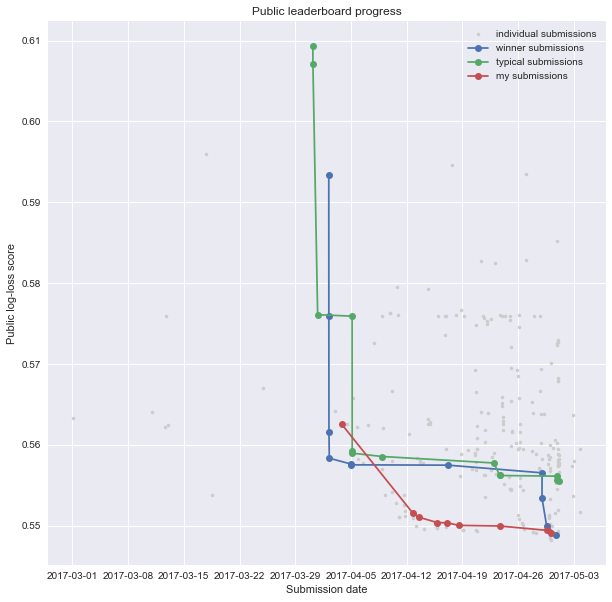

In [277]:
fig, _ = plt.subplots()
fig.set_size_inches(10, 10)
#xx = pd.to_numeric(leaderboard['SubmissionDate'])
#_ = plt.plot(np.unique(x), np.poly1d(np.polyfit(xx, y, 2))(np.unique(xx)))

_ = plt.plot(leaderboard['SubmissionDate'], leaderboard['Score'], 
         '.', color = '0.8', label = 'individual submissions')

labels = ['winner submissions', 'typical submissions', 'my submissions']
for team, label in zip(teams, labels):
    _ = plt.plot(team['SubmissionDate'], team['Score'],
                 linestyle = '-', marker = 'o', label = label);

_ = plt.legend()
_ = plt.title('Public leaderboard progress')
_ = plt.xlabel('Submission date')
_ = plt.ylabel('Public log-loss score')

Below is my progress in more detail on both the public and private leaderboards.

In [6]:
my_progress = pd.read_excel('my_submissions.xlsx')

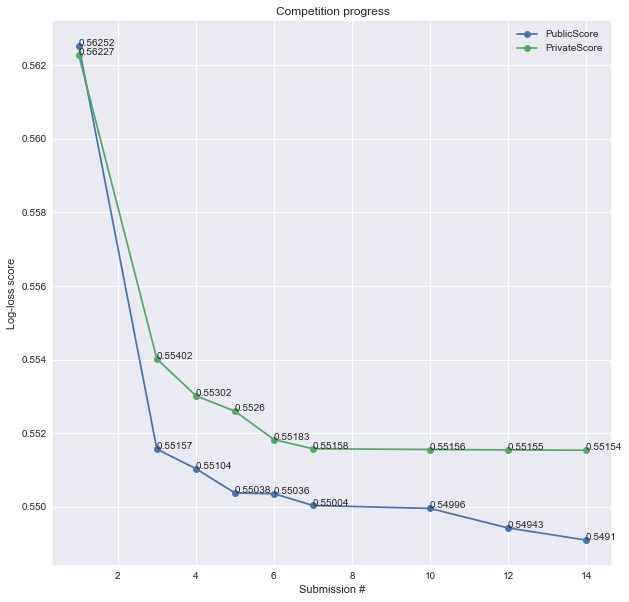

In [7]:
labels = [my_progress['PublicScore'].tolist(), my_progress['PrivateScore'].tolist()]
cols_progress = ['PublicScore', 'PrivateScore']

fig, _ = plt.subplots()
fig.set_size_inches(10, 10)

#plot public and private leaderboard scores
#submissions that did not result in improved scores are not plotted
for col, label in zip(cols_progress, labels):
    p = plt.plot(my_progress['SubmissionNum'], my_progress[col],
                linestyle = '-', marker = 'o');
    
    #annotate points with log-loss score
    for l, x, y in zip(label, my_progress['SubmissionNum'], my_progress[col]):
        p = plt.annotate(l, xy = (x, y))
    
    #chart labels
    p = plt.legend();
    p = plt.title('Competition progress')
    p = plt.xlabel('Submission #');
    p = plt.ylabel('Log-loss score')

p.figure.savefig('competition-progress.png')

The largest drop in log-loss was when we moved from a random forest to a gradient boosted tree model implemented via XGBoost (submission 1 vs. submission 3). Further tuning of the XGBoost model led to a significant decrease in both private and public log-loss scores (submissions 4-6). In submissions 7 and 10 we tested ensemble and stacked models, which led to modest improvements relative to XGBoost alone. In the final two submissions, the decrease in log-loss was greater for the public score than the private score, suggesting that overfitting to the public leaderboard data may have started to occur.

## Predicting likelihood of voting

Ultimately the goal of this project is to predict, and potentially understand, whether a Colorado voter participated in the 2016 election. An important first step in achieving this goal is to decide on a probability threshold above which an observation will be scored as a positive case (will vote) and below which will be scored as a negative case (will not vote). Real-world goals and constraints will need to be balanced to determine the best threshold to maximize the true positive rate (TPR) while minimizing the false positive rate (FPR). We can generate a ROC curve to get an idea of what kind of rates we can achieve.

In [6]:
#load X and y training matrices and final classifier
X_train_card = np.loadtxt('final_train.csv', delimiter = ',')
y_vector = np.loadtxt('final_y.csv', delimiter = ',')

sclf = joblib.load('final_sclf.pkl') 

As we do not have the responses of the actual competition test set, we will have to generate a test set from our training data to calculate TPR and FPRs to generate the ROC curve.

In [7]:
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X_train_card, 
                                                                    y_vector, 
                                                                    test_size = 0.5,
                                                                    random_state = 0)

y_score = sclf.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)

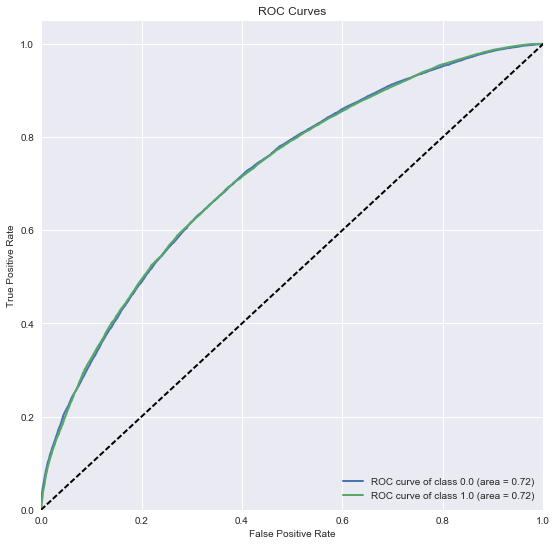

In [13]:
_ = skplt.plot_roc_curve(y_test_roc, y_score, curves = 'each_class',
                        figsize = (9, 9));

We will assume that the true test set has the same proportion of individuals who voted and did not vote as the train set and we will pick the threshold that gives us the proportion that is closest to that of the train set.

In [12]:
train = wv.load_data('train_renamed.csv')

print('{0:.1f}% of individuals in the training set voted in the 2016 election in Colorado.'\
     .format(len(train.loc[train['voted'] == 'Y']) / len(train) * 100))

67.8% of individuals in the training set voted in the 2016 election in Colorado.


In [9]:
#load df with predicted probabilities of voting
pred_test = wv.load_data('pred_test.csv')

#test different thresholds for predicting someone will vote
thresholds = [0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    len(pred_test.loc[pred_test['voted_proba'] > threshold]) / len(pred_test)

0.9331308529486206

0.8508731966590737

0.6984054669703872

0.5100227790432802

Using a threshold greater than 0.6 leads to predicting ~69.8% of the test set will vote. Let's test finer threshold divisions to see if we can get a proportion that more closely mirrors that seen in the training set. 

In [10]:
thresholds = [0.58, 0.59, 0.6, 0.61, 0.62]
for threshold in thresholds:
    len(pred_test.loc[pred_test['voted_proba'] > threshold]) / len(pred_test)

0.7317641103518097

0.7136168058719311

0.6984054669703872

0.6816502151354088

0.6649708934446975

Let's choose a threshold of 0.61, that is, any observations with a predicted probability greater than 0.61 will be scored as 'Y', and everyone else will be scored as 'N'.

In [11]:
pred_list = pred_test['voted_proba'].tolist()
vote = []
for i in pred_list:
    if i > 0.61:
        vote.append('Y')
    else:
        vote.append('N')

pred_test['voted_pred'] = vote
pred_test.head()

,gender,congress_district,state_house,age,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg,dist_ballot,dist_poll,voted_proba,voted_pred
0,M,2,52,30,L,Caucasian,19.5,21.2,25.3,9.8,16.6,45.2,28.4,393,2.521099,2.770852,0.636529,Y
1,F,5,19,20,U,Caucasian,39.7,20.2,29.1,12.0,14.4,41.4,32.2,668,3.143472,3.972788,0.491942,N
2,M,4,44,56,R,Caucasian,11.3,62.7,41.3,14.8,14.7,36.0,34.6,606,2.736109,2.859035,0.694913,Y
3,F,7,34,20,R,Caucasian,32.8,11.6,33.1,14.5,10.3,44.6,30.6,565,2.136312,2.329654,0.612622,Y
4,F,6,41,26,D,Uncoded,10.2,14.7,22.4,8.2,18.4,43.5,29.9,336,2.785245,2.904892,0.816451,Y


Let's calculate the approximate FPR and TPR of this threshold.

In [25]:
fpr, tpr, thresholds = roc_curve(y_test_roc, y_score[:, 1])
roc_info = pd.DataFrame([fpr, tpr, thresholds]).transpose()
roc_info.columns = ['fpr', 'tpr', 'thresholds']

roc_info.ix[(roc_info['thresholds'] > 0.6099) & (roc_info['thresholds'] <= 0.6101)].mean()

fpr           0.471184
tpr           0.773341
thresholds    0.610024
dtype: float64

We get an approximate FPR of 0.47 and an approximate TPR of 0.77. On the ROC curve we can see this corresponds to a point towards the upper right of the curve.

## Exploring features with high importance scores

A disadvantage of ensemble and stacking classifiers is the difficulty of interpreting the predictions of these models. However, the individual models can be assessed for feature importances (tree-based models) or coefficients from the logistic regression. Let's load the trained models and investigate importance scores and coefficients.

In [ ]:
logit = joblib.load('final_logit.pkl')
xgb = joblib.load('final_xgb.pkl')
rf1 = joblib.load('final_rf1.pkl')
rf2 = joblib.load('final_rf2.pkl')

In [47]:
#get list of features used to train the models
feat_cols = train.drop(['voted', 
                        'dist_ballot', 
                        'dist_poll'], 
                       axis = 1).columns.tolist()

We can first view the coefficients from the logistic regression model. Let's first define a local function that will generate a df of importance scores or coefficients from our trained models and then merge all the resulting dataframes together.

In [40]:
def importance_scores(clf, clf_name, feat_cols, coef = False, col_name = 'features'):
    
    if coef:
        score = clf.coef_.tolist()[0]
    else:
        score = clf.feature_importances_
    
    df = pd.DataFrame(list(zip(feat_cols, score)),
                     columns = [col_name, clf_name])
    return df

In [83]:
#merge individual importance scores together
features = pd.merge(pd.merge(pd.merge(importance_scores(xgb, 'xgb', feat_cols), 
                                      importance_scores(rf1, 'rf1', feat_cols),
                                      on = 'features'), 
                             importance_scores(rf2, 'rf2', feat_cols), 
                             on = 'features'),
                    importance_scores(logit, 'logit', feat_cols, coef = True), 
                    on = 'features')

To compare the coefficients we will have to take the absolute value of the coefficients from logistic regression, so let's save the original values into a separate dataframe.

In [86]:
coefs = features[['features', 'logit']]
features['logit'] = features['logit'].abs()

Let's rank each of the features by their maximum values so we can compare features across the four models.

In [88]:
#temporarily drop features column as we don't want to rank it
features.drop('features', axis = 1, inplace = True)
features = features.rank(method = 'max')

#add back features column
features['features'] = coefs['features']

In [89]:
#pivot df so it can be plotted
features_pivot = (
    features.set_index('features')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns = {'level_1': 'model', 0: 'importance'})
)

features_pivot.head()

,features,model,importance
0,gender,xgb,1.0
1,gender,rf1,1.0
2,gender,rf2,2.0
3,gender,logit,9.0
4,congress_district,xgb,4.0


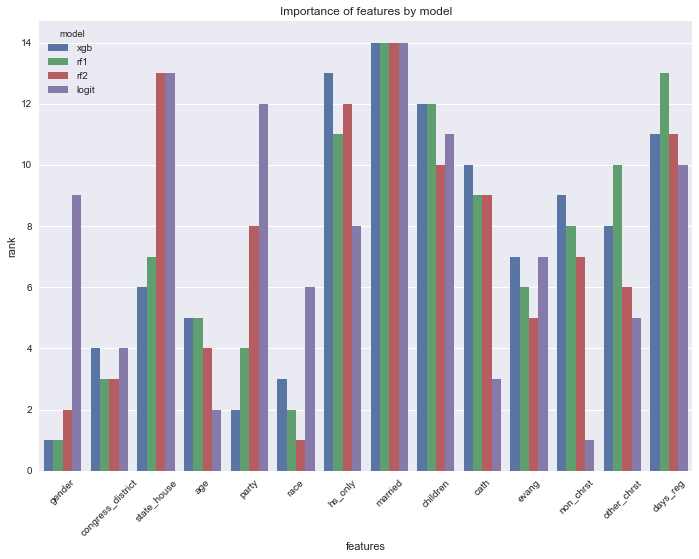

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27);
p = sns.barplot(x = 'features', y = 'importance', 
                hue = 'model', data = features_pivot);
_ = p.set(xlabel = 'features', ylabel = 'rank', 
          title = 'Importance of features by model');
_ = plt.setp(p.get_xticklabels(), rotation=45);

In [96]:
coefs.loc[7, 'logit']

0.60792154188218184

All four models predict the likelihood of being married as the most important variable for classification. From the logistic regression, we can interpret the coefficient as a 0.1 increase in the likelihood score of being married results in an increased probability of ~0.61 of voting on the logit scale, all other predictors being equal. Although the actual magnitude of effect of married is different in the final stacked classifier, we can get a sense that the likelihood of being married has a strong effect on the likelihood of voting.

There is less ‘consensus’ amongst the four models as to the other predictors, although hs_only, children and days_reg generally ranked high. Let's plot married and these three variables grouped by whether the model predicted the individual is likely to vote or not.

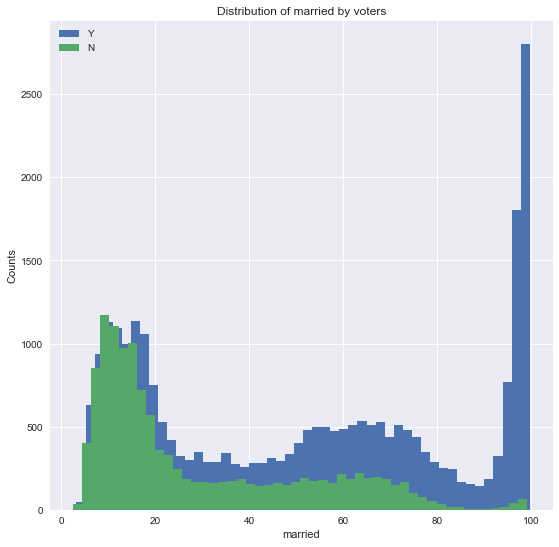

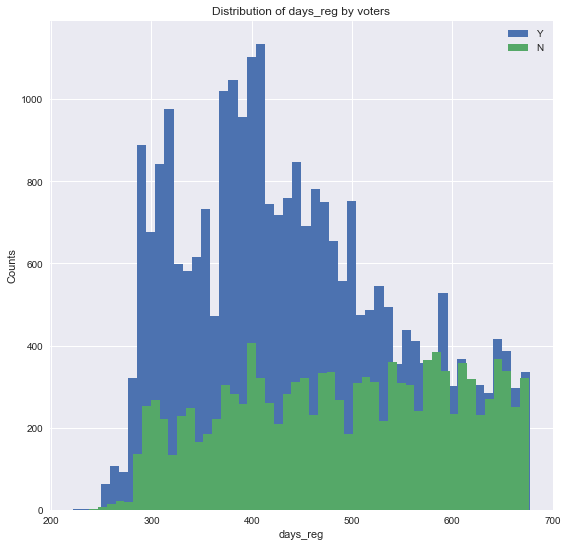

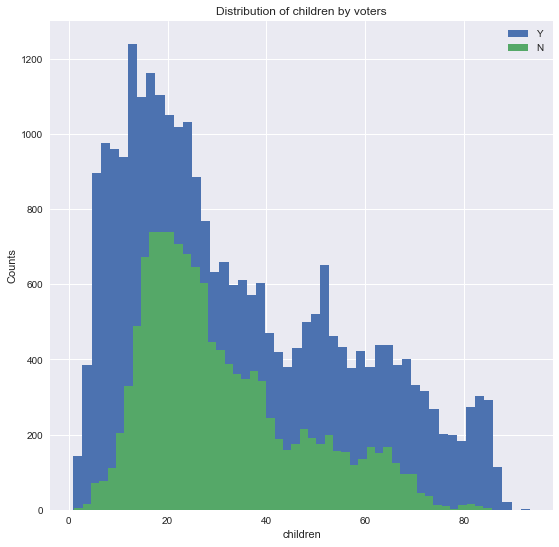

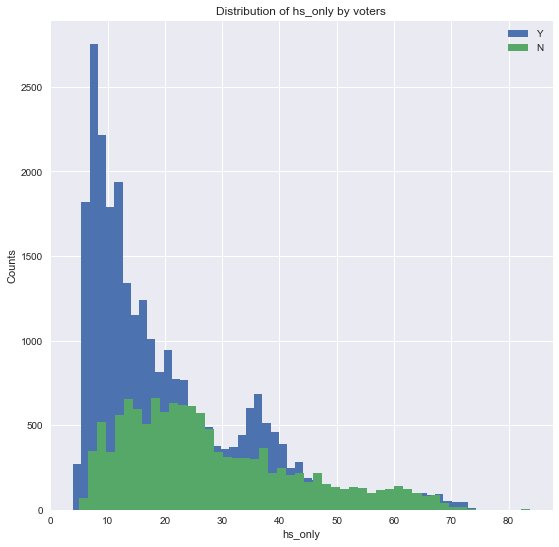

In [276]:
feat_to_plot = ['married', 'days_reg', 'children', 'hs_only']
for feat in feat_to_plot:
    _ = wv.plot_quant(pred_test, feat);

We can see that there is a shift in the distribution of these predictors depending on whether the individuals were predicted to vote or not. The final stacked model predicts that individuals with higher marriage likelihood scores are more likely to vote than not vote, as the number of days since registration increases, the proportion of those who are unlikely to vote increases, a very low and a very high likelihood score of having children are associated with an increased likelihood of voting and those who are likely to vote are overrepresented in the low hs_only score range. Note that in the plots above, the 'Y' group is plotted in blue and the 'N' group is plotted in green, in contrast to the other plots.

In addition to the features described above, state_house was ranked as the second most important feature from one of the random forest classifiers and also had a large coefficient magnitude in logistic regression. Investigating this feature we can see that certain state house districts are predicted to have relatively low voter turnout.

In [20]:
#group observations by state house district and predicted voter turnout
voting_by_sh = pd.DataFrame(pred_test.groupby('state_house')['voted_pred'].value_counts())

#get list of state houses where the predicted # N > predicted # Y
sh_unique = voting_by_sh.index.get_level_values('state_house').unique()
sh_list = []
for sh in sh_unique:
    if voting_by_sh.xs([sh, 'Y'], level = ['state_house', 'voted_pred']).iloc[0, 0] < \
    voting_by_sh.xs([sh, 'N'], level = ['state_house', 'voted_pred']).iloc[0, 0]:
        sh_list.append(sh)

In [21]:
#filter df state house districts that had low voter turnout
sh_df_list = []
for i in sh_list:
    sh_df_list.append(pred_test.ix[pred_test['state_house'] == i])

sh_df = pd.concat(sh_df_list)
sh_df['state_house'].value_counts()

18    803
17    744
61    712
16    658
21    648
50    490
57    483
47    478
42    436
62    407
65    329
Name: state_house, dtype: int64

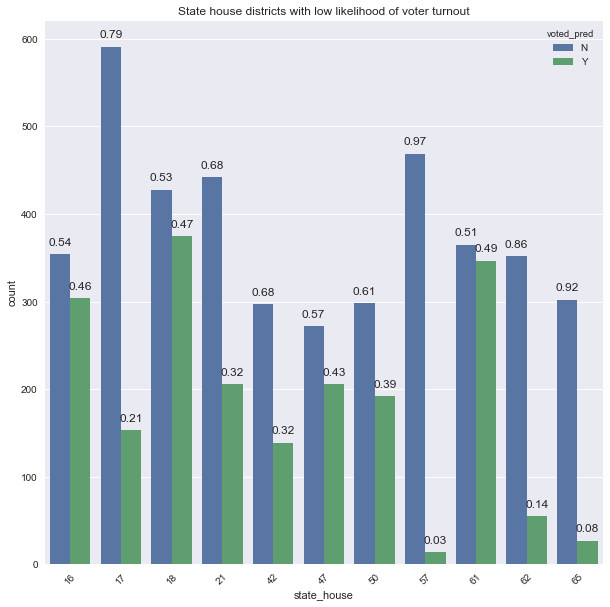

In [22]:
_ = wv.plot_categ_by_voted(sh_df, 'state_house', col_response = 'voted_pred');
_ = plt.title('State house districts with low likelihood of voter turnout')

There are 11 state house districts where voter turnout is predicted to be very low, particularly in districts 57, 65 and 62. Transformation of this high-cardinal variable to a continuous one likely helped the final model identify and use this information in making predictions.

### Final conclusions

In summary, the final model predicts that a Colorado voter with a low likelihood of being married, a longer period since voter registration, a moderately low likelihood of having children, a higher likelihood score of only have a high school degree and who lived in certain state house districts were the least likely to vote in the 2016 election. Individuals that fall within one or several of these categories could be targeted for voter turnout campaigns in future elections. Importantly, analysis of variables in this notebook was based off a particular threshold, and these could change depending on the threshold for predicting whether an individual will or will not vote. Another caveat to keep in mind is that there is an assumption that voter turnout and the variables driving it are similar from year to year. However, it is possible that 2016 was an atypical year, therefore analysis of data from other election cycles should also be performed to determine how representative voter turnout in 2016 is of general elections. Combined with research on what techniques can convince people to vote (calling, door-to-door visits, etc.), understanding which individuals are likely or unlikely to vote could potentially increase voter participation in the future.